This file is used to download Kaggle datasets into a personal Google Drive.
In order to use this, we need a kaggle.json file, which contains the API credentials.
To obtain a kaggle.json file, sign into your Kaggle account and go to your profile, then 'My Account'. Under the API section, click 'Create New API Token' to generate the kaggle.json file. Afterwards, save it in the same directory as this .ipynb file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import f1_score

In [ ]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}
dataset_df = pd.read_csv('/content/drive/MyDrive/9417project/train.csv', dtype=dtypes)


In [ ]:
labels=pd.read_csv('/content/drive/MyDrive/9417project/train_labels.csv')

In [ ]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
labels.head(3)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1


In [ ]:
# Reference: https://www.kaggle.com/code/mannubhardwaj1022/we-r-xgb-boost-model?scriptVersionId=128450896&cellId=18
#original data
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs, axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df


In [ ]:
# feature engine ver2
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
BINNING = ['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

# Define feature engineering function
def feature_engineer_ver2(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = c + '_nunique'
        dfs.append(tmp)

    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = c + '_mean'
        dfs.append(tmp)

        # Compute standard deviation only for certain features
        if c in BINNING:
            tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
            tmp.name = c + '_std'
            dfs.append(tmp)

        # Binning
        if c in BINNING:  # Check if column is in the list of columns to bin
            dataset_df[c+'_bin'] = pd.qcut(dataset_df[c], q=4, duplicates='drop')
            tmp = dataset_df.groupby(['session_id','level_group'])[c+'_bin'].agg('count')
            tmp.name = c + '_bin_count'
            dfs.append(tmp)

           # Interaction between screen coordinates
    if 'screen_coor_x' in NUMERICAL and 'screen_coor_y' in NUMERICAL:
        # Compute Euclidean distance instead of product
        dataset_df['screen_coor'] = np.sqrt(dataset_df['screen_coor_x']**2 + dataset_df['screen_coor_y']**2)
        tmp = dataset_df.groupby(['session_id','level_group'])['screen_coor'].agg(['mean', 'std'])
        tmp.columns = ['screen_coor_mean', 'screen_coor_std']
        dfs.append(tmp)

    # Aggregated features
    if 'hover_duration' in NUMERICAL:
        dataset_df['total_hover_duration'] = dataset_df.groupby(['session_id'])['hover_duration'].transform('sum')
        tmp = dataset_df.groupby(['session_id','level_group'])['total_hover_duration'].agg('mean')
        tmp.name = 'total_hover_duration_mean'
        dfs.append(tmp)

    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')

    dataset_df['screen_coor_mean'] = dataset_df['screen_coor_mean'].astype('int32')
    for col in dataset_df.select_dtypes(include='float16').columns:
        dataset_df[col] = dataset_df[col].astype('float32')

    return dataset_df

In [ ]:
#feature engine ver3
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
BINNING = ['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

from sklearn.preprocessing import PowerTransformer

def feature_engineer_ver3(dataset_df):
    dfs = []
    pt = PowerTransformer(method='yeo-johnson')

    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = c + '_nunique'
        dfs.append(tmp)

        # Create dummy variables for top N most common events and names
        top_N = dataset_df[c].value_counts()[:10].index
        for val in top_N:
            dataset_df[c + '_' + val] = (dataset_df[c] == val).astype(int)
        tmp = dataset_df.groupby(['session_id','level_group']).agg({c + '_' + val: 'sum' for val in top_N})
        dfs.append(tmp)

    for c in NUMERICAL:
        # Fill missing values with the column median
        dataset_df[c].fillna(dataset_df[c].median(), inplace=True)

        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = c + '_mean'
        dfs.append(tmp)

        # Compute standard deviation only for certain features
        if c in BINNING:
            tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
            tmp.name = c + '_std'
            dfs.append(tmp)

        # Normalize 'elapsed_time' column
        if c == 'elapsed_time':
            dataset_df[c] = pt.fit_transform(dataset_df[[c]])

        # Binning
        if c in BINNING:  # Check if column is in the list of columns to bin
            dataset_df[c+'_bin'] = pd.qcut(dataset_df[c], q=4, duplicates='drop')
            #dataset_df[c+'_bin'] = pd.qcut(dataset_df[c], q=4, duplicates='drop').astype('category')

            tmp = dataset_df.groupby(['session_id','level_group'])[c+'_bin'].agg('count')
            tmp.name = c + '_bin_count'
            dfs.append(tmp)

    # Interaction between screen coordinates
    if 'screen_coor_x' in NUMERICAL and 'screen_coor_y' in NUMERICAL:
        # Compute Euclidean distance instead of product
        dataset_df['screen_coor'] = np.sqrt(dataset_df['screen_coor_x']**2 + dataset_df['screen_coor_y']**2)
        tmp = dataset_df.groupby(['session_id','level_group'])['screen_coor'].agg(['mean', 'std'])
        tmp.columns = ['screen_coor_mean', 'screen_coor_std']
        dfs.append(tmp)

    # Aggregated features
    if 'hover_duration' in NUMERICAL:
        dataset_df['total_hover_duration'] = dataset_df.groupby(['session_id'])['hover_duration'].transform('sum')
        tmp = dataset_df.groupby(['session_id','level_group'])['total_hover_duration'].agg('mean')
        tmp.name = 'total_hover_duration_mean'
        dfs.append(tmp)

    dataset_df = pd.concat(dfs, axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')

    return dataset_df


In [ ]:
#feature engine ver4
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer

CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
             'screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer_ver4(dataset_df):
    dfs = []
    le = LabelEncoder()
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

    for c in CATEGORICAL:
        # Label encoding for categorical features
        dataset_df[c+'_encoded'] = le.fit_transform(dataset_df[c].astype(str))
        tmp = dataset_df.groupby(['session_id','level_group'])[c+'_encoded'].agg(['mean', 'std'])
        tmp.columns = [c + '_encoded_mean', c + '_encoded_std']
        dfs.append(tmp)

    for c in NUMERICAL:
        # Fill missing values with the column median
        dataset_df[c].fillna(dataset_df[c].median(), inplace=True)

        # Calculate sum, mean and std for numerical features
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg(['sum', 'mean', 'std'])
        tmp.columns = [c + '_sum', c + '_mean', c + '_std']
        dfs.append(tmp)

        # Apply binning to numerical features
        dataset_df[c+'_binned'] = discretizer.fit_transform(dataset_df[[c]])
        tmp = dataset_df.groupby(['session_id','level_group'])[c+'_binned'].agg(['mean', 'std'])
        tmp.columns = [c + '_binned_mean', c + '_binned_std']
        dfs.append(tmp)

    # Interaction between screen coordinates
    if 'screen_coor_x' in NUMERICAL and 'screen_coor_y' in NUMERICAL:
        # Compute Euclidean distance instead of product
        dataset_df['screen_coor'] = np.sqrt(dataset_df['screen_coor_x']**2 + dataset_df['screen_coor_y']**2)
        tmp = dataset_df.groupby(['session_id','level_group'])['screen_coor'].agg(['sum', 'mean', 'std'])
        tmp.columns = ['screen_coor_sum', 'screen_coor_mean', 'screen_coor_std']
        dfs.append(tmp)

    # Aggregated features
    if 'hover_duration' in NUMERICAL:
        dataset_df['total_hover_duration'] = dataset_df.groupby(['session_id'])['hover_duration'].transform('sum')
        tmp = dataset_df.groupby(['session_id','level_group'])['total_hover_duration'].agg(['mean', 'std'])
        tmp.columns = ['total_hover_duration_mean', 'total_hover_duration_std']
        dfs.append(tmp)

    dataset_df = pd.concat(dfs, axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')

    dataset_df['page_sum'] = dataset_df['page_sum'].astype('int32')
    for col in dataset_df.select_dtypes(include='float16').columns:
        dataset_df[col] = dataset_df[col].astype('float32')

    return dataset_df

In [ ]:
#feature engine ver5
from sklearn.preprocessing import LabelEncoder

def feature_engineer_ver5(data):
    # Encode categorical variables
    categorical_cols = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
    encoder = LabelEncoder()
    for col in categorical_cols:
        data[col] = encoder.fit_transform(data[col])

    # Generate historical features
    # Here we calculate the average elapsed_time for all previous events in the same session
    data['avg_elapsed_time'] = data.groupby('session_id')['elapsed_time'].transform('mean')

    # You can add more historical features as needed
    # For example, count the number of 'navigate_click' events for each session
    data['navigate_click_count'] = data[data['event_name'] == 'navigate_click'].groupby('session_id')['event_name'].transform('count')

    # Or calculate the maximum hover_duration for each session
    data['max_hover_duration'] = data.groupby('session_id')['hover_duration'].transform('max')
    # Count of each event type
    event_counts = data.groupby('session_id')['event_name'].value_counts().unstack(fill_value=0)
    data = data.join(event_counts, on='session_id')

    # Time since the last event
    data['time_since_last_event'] = data.groupby('session_id')['elapsed_time'].diff()

    # Number of events in fullscreen mode
    data['fullscreen_event_count'] = data[data['fullscreen'] == 1].groupby('session_id')['fullscreen'].transform('count')

    # Number of events with music on
    data['music_event_count'] = data[data['music'] == 1].groupby('session_id')['music'].transform('count')

    # Number of unique levels played
    data['unique_levels_count'] = data.groupby('session_id')['level'].transform('nunique')

    return data


In [ ]:
def partial_loader(df):
  split = 5
  epoch_length = df.shape[0]//split
  start = 0
  partial_df = df.iloc[start:start+epoch_length].copy(deep = True)
  partial_df = feature_engineer_ver3(partial_df)
  start += epoch_length
  for i in range(split - 2):
    partial_df = pd.concat([partial_df,feature_engineer_ver3(df.iloc[start:start+epoch_length].copy(deep = True))])
    start += epoch_length
  partial_df = pd.concat([partial_df,feature_engineer_ver3(df.iloc[start:])])
  return partial_df

In [ ]:
#store the cross validation threshold and f1-score data

#apply the feature engineer
#dataset_df+feature_engineer(dataset_df)
#dataset_df=feature_engineer_ver2(dataset_df)
dataset_df = partial_loader(dataset_df)

# Define GroupKFold with 10 splits
gkf = GroupKFold(n_splits=5)

#store the threshold and f1-score data
cross_threshold=[]
cross_f1score=[]

# Select features for the model
features = [c for c in dataset_df.columns if c != 'level_group']

# Get unique session IDs as validation data
valid = dataset_df.index.unique()

# Dictionary to store trained models
models = {}

# DataFrame to store model predictions
out_prediction = pd.DataFrame(data = np.zeros((len(valid), 18)), index = valid)


# Perform cross-validation with GroupKFold

for i, (train_index, test_index) in enumerate(gkf.split(X = dataset_df, groups = dataset_df.index)):
    print(); print()
    print('#' * 40)
    print('#' * 5, ' ' * 10, f'Fold {i+1}', ' ' * 10, '#' * 5)
    print('#' * 40)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.02,
        'max_depth': 4,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
    }

    # Iterate through questions 1 to 18
    for t in range(1, 19):

        # Determine the level group for the current question
        if t >= 0 and t <= 3:
            year_group = '0-4'
        elif t >= 4 and t <= 13:
            year_group = '5-12'
        elif t >= 14 and t <= 22:
            year_group = '13-22'

        # Get the train and validation data for the current question and level group
        x_train = dataset_df.iloc[train_index]
        x_train = x_train.loc[x_train.level_group == year_group]
        train_users = x_train.index.values
        y_train = labels.loc[labels.q == t].set_index('session').loc[train_users]

        x_valid = dataset_df.iloc[test_index]
        x_valid = x_valid.loc[x_valid.level_group == year_group]
        valid_users = x_valid.index.values
        y_valid = labels.loc[labels.q == t].set_index('session').loc[valid_users]

        # Train an XGBoost model for the current question and level group
        model = XGBClassifier(**params)
        model.fit(
            x_train[features].astype('float32'), y_train['correct'],
            eval_set=[(x_valid[features].astype('float32'), y_valid['correct'])],
            verbose=0
        )

        # print out the output
        print(f'Q:{t} (year group: {year_group})(best_num_trees: {model.best_ntree_limit})', end='\n')

        # Store the trained model
        models[f'{year_group}_{t}'] = model

        out_prediction.loc[valid_users, t-1] = model.predict_proba(x_valid[features].astype('float32'))[:, 1]
    # Create a copy of the out_prediction DataFrame
    true_table = out_prediction.copy()

    # Iterate through the questions (indices 0 to 17)
    for i in range(18):
        # Filter the labels DataFrame for the current question and select the corresponding sessions in the validation set
        tmp = labels.loc[labels.q == i + 1].set_index('session').loc[valid]

        # Update the i-th column of the true_table DataFrame with the 'correct' values from tmp
        true_table[i] = tmp.correct.values
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    # Iterate through a range of thresholds from 0.4 to 0.8 with a step size of 0.01
    for threshold in np.arange(0.4, 0.81, 0.01):
        print(f'threshold: {threshold:.02f}, ', end='')

        # Convert the predicted probabilities in out_prediction to binary predictions using the current threshold
        preds = (out_prediction.values.reshape((-1)) > threshold).astype('int')

        # Calculate the macro-average F1 score between the true_table and the binary predictions
        m = f1_score(true_table.values.reshape((-1)), preds, average='macro')

        # Append the F1 score and threshold to the scores and thresholds lists, respectively
        scores.append(m)
        thresholds.append(threshold)

        # Check if the current F1 score is better than the previous best score
        if m > best_score:
            best_score = m
            best_threshold = threshold
    m = f1_score(true_table.values.reshape((-1)), (out_prediction.values.reshape((-1)) > best_threshold).astype('int'), average='macro')
    cross_threshold.append(best_threshold)
    cross_f1score.append(m)


<ipython-input-16-56b7362d1bc5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[c + '_' + val] = (dataset_df[c] == val).astype(int)
<ipython-input-16-56b7362d1bc5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[c + '_' + val] = (dataset_df[c] == val).astype(int)
<ipython-input-16-56b7362d1bc5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:



########################################
#####            Fold 1            #####
########################################
Q:1 (year group: 0-4)(best_num_trees: 366)
Q:2 (year group: 0-4)(best_num_trees: 341)
Q:3 (year group: 0-4)(best_num_trees: 244)
Q:4 (year group: 5-12)(best_num_trees: 720)
Q:5 (year group: 5-12)(best_num_trees: 380)
Q:6 (year group: 5-12)(best_num_trees: 350)
Q:7 (year group: 5-12)(best_num_trees: 540)
Q:8 (year group: 5-12)(best_num_trees: 182)
Q:9 (year group: 5-12)(best_num_trees: 378)
Q:10 (year group: 5-12)(best_num_trees: 733)
Q:11 (year group: 5-12)(best_num_trees: 270)
Q:12 (year group: 5-12)(best_num_trees: 267)
Q:13 (year group: 5-12)(best_num_trees: 226)
Q:14 (year group: 13-22)(best_num_trees: 392)
Q:15 (year group: 13-22)(best_num_trees: 462)
Q:16 (year group: 13-22)(best_num_trees: 214)
Q:17 (year group: 13-22)(best_num_trees: 164)
Q:18 (year group: 13-22)(best_num_trees: 422)
threshold: 0.40, threshold: 0.41, threshold: 0.42, threshold: 0.43, thre

In [ ]:
print(cross_threshold)
print(cross_f1score)

[0.4600000000000001, 0.5200000000000001, 0.5600000000000002, 0.6100000000000002, 0.6300000000000002]
[0.377795655679222, 0.4784413635004729, 0.5568253186065049, 0.6216093042466133, 0.6832714008242933]


In [ ]:
# Reference: https://www.kaggle.com/code/mannubhardwaj1022/we-r-xgb-boost-model?scriptVersionId=128450896&cellId=18
#use the best performance engineer to generate data
dataset_df = partial_loader(dataset_df)

# Define GroupKFold with 10 splits
gkf = GroupKFold(n_splits=10)

# Select features for the model
features = [c for c in dataset_df.columns if c != 'level_group']

# Get unique session IDs as validation data
valid = dataset_df.index.unique()

# Dictionary to store trained models
models = {}

# DataFrame to store model predictions
out_prediction = pd.DataFrame(data = np.zeros((len(valid), 18)), index = valid)


# Perform cross-validation with GroupKFold

for i, (train_index, test_index) in enumerate(gkf.split(X = dataset_df, groups = dataset_df.index)):
    print(); print()
    print('#' * 40)
    print('#' * 5, ' ' * 10, f'Fold {i+1}', ' ' * 10, '#' * 5)
    print('#' * 40)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.02,
        'max_depth': 4,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
    }

    # Iterate through questions 1 to 18
    for t in range(1, 19):

        # Determine the level group for the current question
        if t >= 0 and t <= 3:
            year_group = '0-4'
        elif t >= 4 and t <= 13:
            year_group = '5-12'
        elif t >= 14 and t <= 22:
            year_group = '13-22'

        # Get the train and validation data for the current question and level group
        x_train = dataset_df.iloc[train_index]
        x_train = x_train.loc[x_train.level_group == year_group]
        train_users = x_train.index.values
        y_train = labels.loc[labels.q == t].set_index('session').loc[train_users]

        x_valid = dataset_df.iloc[test_index]
        x_valid = x_valid.loc[x_valid.level_group == year_group]
        valid_users = x_valid.index.values
        y_valid = labels.loc[labels.q == t].set_index('session').loc[valid_users]

        # Train an XGBoost model for the current question and level group
        model = XGBClassifier(**params)
        model.fit(
            x_train[features].astype('float32'), y_train['correct'],
            eval_set=[(x_valid[features].astype('float32'), y_valid['correct'])],
            verbose=0
        )

        # print out the output
        print(f'Q:{t} (year group: {year_group})(best_num_trees: {model.best_ntree_limit})', end='\n')

        # Store the trained model
        models[f'{year_group}_{t}'] = model

        out_prediction.loc[valid_users, t-1] = model.predict_proba(x_valid[features].astype('float32'))[:, 1]




########################################
#####            Fold 1            #####
########################################
Q:1 (year group: 0-4)(best_num_trees: 290)
Q:2 (year group: 0-4)(best_num_trees: 565)
Q:3 (year group: 0-4)(best_num_trees: 235)
Q:4 (year group: 5-12)(best_num_trees: 565)
Q:5 (year group: 5-12)(best_num_trees: 462)
Q:6 (year group: 5-12)(best_num_trees: 485)
Q:7 (year group: 5-12)(best_num_trees: 579)
Q:8 (year group: 5-12)(best_num_trees: 285)
Q:9 (year group: 5-12)(best_num_trees: 507)
Q:10 (year group: 5-12)(best_num_trees: 413)
Q:11 (year group: 5-12)(best_num_trees: 529)
Q:12 (year group: 5-12)(best_num_trees: 195)
Q:13 (year group: 5-12)(best_num_trees: 282)
Q:14 (year group: 13-22)(best_num_trees: 385)
Q:15 (year group: 13-22)(best_num_trees: 403)
Q:16 (year group: 13-22)(best_num_trees: 192)
Q:17 (year group: 13-22)(best_num_trees: 194)
Q:18 (year group: 13-22)(best_num_trees: 389)


########################################
#####            Fold 2      

In [ ]:
# Create a copy of the out_prediction DataFrame
true_table = out_prediction.copy()

# Iterate through the questions (indices 0 to 17)
for i in range(18):
    # Filter the labels DataFrame for the current question and select the corresponding sessions in the validation set
    tmp = labels.loc[labels.q == i + 1].set_index('session').loc[valid]

    # Update the i-th column of the true_table DataFrame with the 'correct' values from tmp
    true_table[i] = tmp.correct.values


In [ ]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

# Iterate through a range of thresholds from 0.4 to 0.8 with a step size of 0.01
for threshold in np.arange(0.4, 0.81, 0.01):
    print(f'threshold: {threshold:.02f}, ', end='')

    # Convert the predicted probabilities in out_prediction to binary predictions using the current threshold
    preds = (out_prediction.values.reshape((-1)) > threshold).astype('int')

    # Calculate the macro-average F1 score between the true_table and the binary predictions
    m = f1_score(true_table.values.reshape((-1)), preds, average='macro')

    # Append the F1 score and threshold to the scores and thresholds lists, respectively
    scores.append(m)
    thresholds.append(threshold)

    # Check if the current F1 score is better than the previous best score
    if m > best_score:
        best_score = m
        best_threshold = threshold


threshold: 0.40, threshold: 0.41, threshold: 0.42, threshold: 0.43, threshold: 0.44, threshold: 0.45, threshold: 0.46, threshold: 0.47, threshold: 0.48, threshold: 0.49, threshold: 0.50, threshold: 0.51, threshold: 0.52, threshold: 0.53, threshold: 0.54, threshold: 0.55, threshold: 0.56, threshold: 0.57, threshold: 0.58, threshold: 0.59, threshold: 0.60, threshold: 0.61, threshold: 0.62, threshold: 0.63, threshold: 0.64, threshold: 0.65, threshold: 0.66, threshold: 0.67, threshold: 0.68, threshold: 0.69, threshold: 0.70, threshold: 0.71, threshold: 0.72, threshold: 0.73, threshold: 0.74, threshold: 0.75, threshold: 0.76, threshold: 0.77, threshold: 0.78, threshold: 0.79, threshold: 0.80, 

In [ ]:
print(best_threshold)

0.6200000000000002


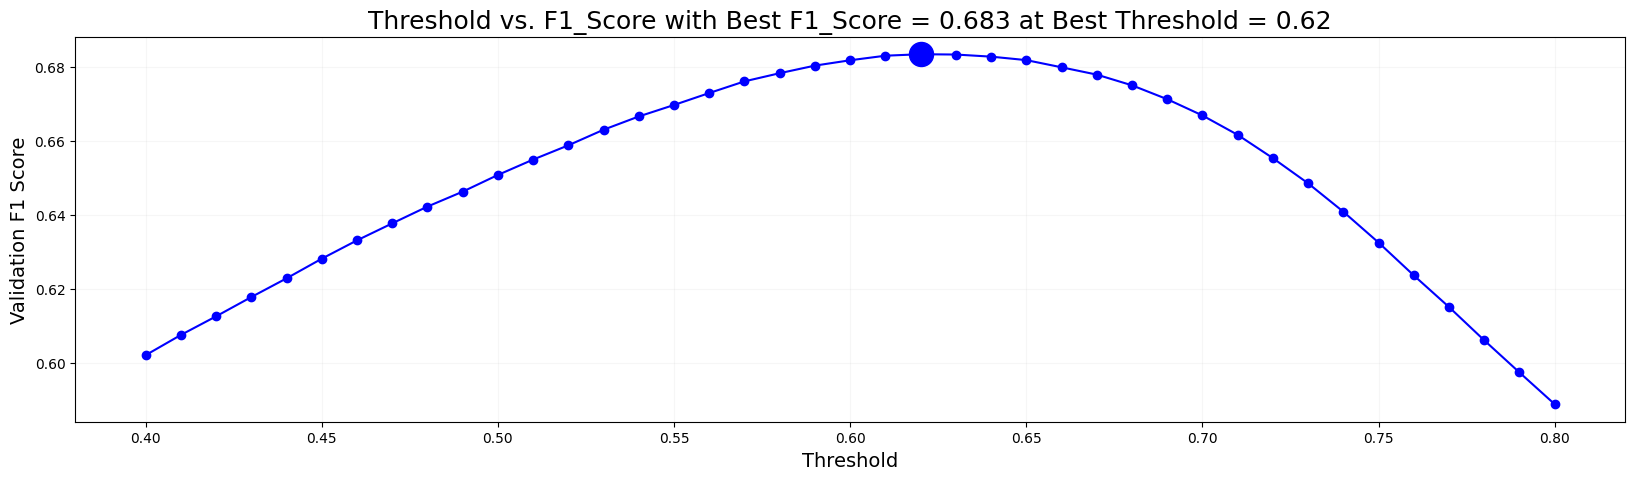

In [ ]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize = (20, 5))
plt.plot(thresholds, scores, '-o', color = 'blue')
plt.scatter([best_threshold], [best_score], color = 'blue', s = 300, alpha = 1)
plt.xlabel('Threshold', size = 14)
plt.ylabel('Validation F1 Score', size = 14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.grid(alpha=0.1)
plt.show()

In [ ]:
print('When using optimal threshold...')
for k in range(18):

    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true_table[k].values, (out_prediction[k].values > best_threshold).astype('int'), average='macro')
    print(f'Question{k+1}: F1 =',m)

# COMPUTE F1 SCORE OVERALL
m = f1_score(true_table.values.reshape((-1)), (out_prediction.values.reshape((-1)) > best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Question1: F1 = 0.6280606149516108
Question2: F1 = 0.49463795470144134
Question3: F1 = 0.4917037280762112
Question4: F1 = 0.6334638045420599
Question5: F1 = 0.6051399182213136
Question6: F1 = 0.6181850783301454
Question7: F1 = 0.5958093544067113
Question8: F1 = 0.5516713124809951
Question9: F1 = 0.6103384172327457
Question10: F1 = 0.5455642264913485
Question11: F1 = 0.5945900020378949
Question12: F1 = 0.5010896874605112
Question13: F1 = 0.43978888745193245
Question14: F1 = 0.6077571765754826
Question15: F1 = 0.5392553148369577
Question16: F1 = 0.45968945954016127
Question17: F1 = 0.5379888135802849
Question18: F1 = 0.4873145045476305
==> Overall F1 = 0.6833348222588915


In [ ]:
#import the results of other two models and adjust the xgb data
LSTM_file_path ='/content/drive/MyDrive/9417project/predictions/LSTM_pred.npy'
SVM_file_path ='/content/drive/MyDrive/9417project/predictions/SVM_pred.npy'
LSTM_pred = np.load(LSTM_file_path,allow_pickle=True)
SVM_pred = np.load(SVM_file_path,allow_pickle=True)
XGB_pred=out_prediction[-4713:].copy()
ensemble_true_table=true_table[-4713:].copy()

In [ ]:
import csv

In [ ]:
#try ensemble three models with different portition
for i in np.arange(0,1,0.05):
  for j in np.arange(0,1-i,0.01):
    print(f'i:{i},j:{j}',end='\n')
    ensemble=i*XGB_pred+j*SVM_pred+(1-i-j)*LSTM_pred
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0
    # Iterate through a range of thresholds from 0.4 to 0.8 with a step size of 0.01
    for threshold in np.arange(0.4, 0.81, 0.01):
        # print(f'threshold: {threshold:.02f}, ', end='')

        # Convert the predicted probabilities in out_prediction to binary predictions using the current threshold
        preds = (ensemble.values.reshape((-1)) > threshold).astype('int')

        # Calculate the macro-average F1 score between the true_table and the binary predictions
        m = f1_score(ensemble_true_table.values.reshape((-1)), preds, average='macro')

        # Append the F1 score and threshold to the scores and thresholds lists, respectively
        scores.append(m)
        thresholds.append(threshold)

        # Check if the current F1 score is better than the previous best score
        if m > best_score:
            best_score = m
            best_threshold = threshold
    best_score = f1_score(ensemble_true_table.values.reshape((-1)), (ensemble.values.reshape((-1)) > best_threshold).astype('int'), average='macro')
    with open('ensemble_data.csv','a',newline='') as file:
      writer=csv.writer(file)
      headers=['portion for xgb','portion for SVM','portion for LSTM','threshold','f1_score']
      if not headers:
        writer.writerow(headers)
      writer.writerow((i,j,1-i-j,best_threshold,best_score))

i:0.0,j:0.0
i:0.0,j:0.01
i:0.0,j:0.02
i:0.0,j:0.03
i:0.0,j:0.04
i:0.0,j:0.05
i:0.0,j:0.06
i:0.0,j:0.07
i:0.0,j:0.08
i:0.0,j:0.09
i:0.0,j:0.1
i:0.0,j:0.11
i:0.0,j:0.12
i:0.0,j:0.13
i:0.0,j:0.14
i:0.0,j:0.15
i:0.0,j:0.16
i:0.0,j:0.17
i:0.0,j:0.18
i:0.0,j:0.19
i:0.0,j:0.2
i:0.0,j:0.21
i:0.0,j:0.22
i:0.0,j:0.23
i:0.0,j:0.24
i:0.0,j:0.25
i:0.0,j:0.26
i:0.0,j:0.27
i:0.0,j:0.28
i:0.0,j:0.29
i:0.0,j:0.3
i:0.0,j:0.31
i:0.0,j:0.32
i:0.0,j:0.33
i:0.0,j:0.34
i:0.0,j:0.35000000000000003
i:0.0,j:0.36
i:0.0,j:0.37
i:0.0,j:0.38
i:0.0,j:0.39
i:0.0,j:0.4
i:0.0,j:0.41000000000000003
i:0.0,j:0.42
i:0.0,j:0.43
i:0.0,j:0.44
i:0.0,j:0.45
i:0.0,j:0.46
i:0.0,j:0.47000000000000003
i:0.0,j:0.48
i:0.0,j:0.49
i:0.0,j:0.5
i:0.0,j:0.51
i:0.0,j:0.52
i:0.0,j:0.53
i:0.0,j:0.54
i:0.0,j:0.55
i:0.0,j:0.56
i:0.0,j:0.5700000000000001
i:0.0,j:0.58
i:0.0,j:0.59
i:0.0,j:0.6
i:0.0,j:0.61
i:0.0,j:0.62
i:0.0,j:0.63
i:0.0,j:0.64
i:0.0,j:0.65
i:0.0,j:0.66
i:0.0,j:0.67
i:0.0,j:0.68
i:0.0,j:0.6900000000000001
i:0.0,j:0.70000000000000

In [ ]:
#store the ensemble data
data_to_present=pd.read_csv('ensemble_data.csv')
data_to_present=data_to_present.to_numpy()
print(type(data_to_present))
print(data_to_present)
print(np.max(data_to_present[:,4]))

<class 'numpy.ndarray'>
[[0.         0.01       0.99       0.61       0.65037794]
 [0.         0.02       0.98       0.61       0.65037794]
 [0.         0.03       0.97       0.61       0.65037794]
 ...
 [0.95       0.02       0.03       0.63       0.68577383]
 [0.95       0.03       0.02       0.63       0.6857286 ]
 [0.95       0.04       0.01       0.63       0.68571918]]
0.6858085350698129


In [ ]:
import ipywidgets as widgets
from IPython.display import display

In [ ]:
#generate 3d plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_figure(angle):
  fig=plt.figure(figsize=(9,9))
  ax=plt.axes(projection='3d')

  X=data_to_present[:,0]
  Y=data_to_present[:,1]
  Z=data_to_present[:,4]
  Z=Z.reshape(len(Z),1)

  ax.scatter(X,Y,Z,c='b',marker='o')

  ax.set_xlabel('portion for XGB')
  ax.set_ylabel('portion for SVM')
  ax.set_zlabel('f1-score')
  ax.view_init(elev=10, azim=angle)
  plt.savefig('ensemble_f1.png')
  plt.show()

angle_slider = widgets.FloatSlider(value=0, min=0, max=360, step=1, description='Angle')
widgets.interactive(plot_3d_figure, angle=angle_slider)

interactive(children=(FloatSlider(value=0.0, description='Angle', max=360.0, step=1.0), Output()), _dom_classe…

In [ ]:
best_result=np.max(data_to_present[:,4])
for i in range(len(data_to_present[:,4])):
  if data_to_present[i,4]==best_result:
    print(f'the portion for XGB is {data_to_present[i,0]}')
    print(f'the portion for SVM is {data_to_present[i,1]}')
    print(f'the portion for LSTM is {data_to_present[i,2]}')
    print(f'the highest f1-score is {data_to_present[i,4]}')


the portion for XGB is 0.95
the portion for SVM is 0.01
the portion for LSTM is 0.0399999999999999
the highest f1-score is 0.6858085350698129
